In [1]:
import pandas as pd

In [2]:
import pyspark as spark

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
rating = spark.read.csv('CSV_data/anime/rating.csv', header='true', inferSchema='true')

In [6]:
rating.show(5)

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      1|      20|    -1|
|      1|      24|    -1|
|      1|      79|    -1|
|      1|     226|    -1|
|      1|     241|    -1|
+-------+--------+------+
only showing top 5 rows



In [7]:
rating1 = rating.filter('rating>0')

In [8]:
rating1.summary().show()

+-------+-----------------+-----------------+------------------+
|summary|          user_id|         anime_id|            rating|
+-------+-----------------+-----------------+------------------+
|  count|          6337241|          6337241|           6337241|
|   mean|36747.91443421514|8902.866382547232| 7.808496946857473|
| stddev|21013.40308687603|8881.999647314724|1.5724960304974278|
|    min|                1|                1|                 1|
|    25%|            18978|             1239|                 7|
|    50%|            36805|             6213|                 8|
|    75%|            54873|            14075|                 9|
|    max|            73516|            34475|                10|
+-------+-----------------+-----------------+------------------+



In [9]:
rating1.select('user_id').distinct().count()

69600

In [10]:
rating1.select('anime_id').distinct().count()

9927

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [12]:
(training, test) = rating1.randomSplit([.8, .2])

In [13]:
training.select('anime_id').distinct().count()

9730

In [14]:
test.select('anime_id').distinct().count()

8501

In [15]:
als = ALS(maxIter=10, rank=10, regParam=0.1, userCol='user_id', itemCol='anime_id', ratingCol='rating', coldStartStrategy='drop')

In [16]:
model=als.fit(training)

In [17]:
predictions = model.transform(test)

In [18]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [19]:
rmse = evaluator.evaluate(predictions)

In [20]:
print(rmse)

1.1513244161160823


In [22]:
predictions.show(10)

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
|   1591|    2866|     6|  5.976516|
|   4519|    5300|     9|   9.09524|
|    392|   22097|     8| 6.1314306|
|   7168|    5300|     8|  9.478162|
|   7168|    8086|     8|  8.111951|
|  10462|   17389|     8|  8.531713|
|  11316|    1088|     9|  7.705026|
|  18956|    8086|     4| 6.3458405|
|   5287|     463|     8|  8.157484|
|   7387|     471|     7|  6.978129|
+-------+--------+------+----------+
only showing top 10 rows



In [23]:
dfs_rec = model.recommendForAllUsers(5)

In [24]:
dfs_rec.show(10, False)

+-------+----------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                     |
+-------+----------------------------------------------------------------------------------------------------+
|1      |[{22593, 14.317052}, {9077, 11.8611965}, {1355, 11.386504}, {5006, 11.159068}, {32739, 10.70162}]   |
|12     |[{32422, 10.573472}, {30743, 10.16369}, {28851, 10.106679}, {22615, 9.972925}, {22479, 9.972925}]   |
|16     |[{25495, 10.272967}, {32422, 10.094208}, {30743, 9.803534}, {4640, 9.673493}, {9053, 9.4082}]       |
|22     |[{22607, 12.207405}, {30743, 11.670695}, {32422, 11.509097}, {32894, 11.396589}, {22615, 11.359051}]|
|26     |[{9077, 12.127537}, {3252, 11.040165}, {22593, 10.651598}, {4561, 10.238372}, {25495, 10.167312}]   |
|27     |[{22593, 11.469573}, {30743, 10.482974}, {4208, 10.087011}, {25915, 10.065698}, {32422, 10.03127}]  |
|

In [25]:
predictions.filter('prediction < 0').show()

+-------+--------+------+------------+
|user_id|anime_id|rating|  prediction|
+-------+--------+------+------------+
|   6103|     413|     1|  -0.3368714|
|   9408|    3287|     1| -0.27470964|
|  12342|   19315|     1| -0.31005746|
|  29075|   16610|     1| -0.21632682|
|  38309|    1639|     1|-0.024653226|
|  33665|   16604|     1|  -0.9676918|
|  26759|    2245|     3| -0.43153548|
|  24717|    5877|     1| -0.13737315|
|  21976|    8290|     1| -0.32650787|
|  21976|   12059|     1| -0.66957825|
|  24323|     530|     1| -0.29456663|
|  38816|   16608|     1| -0.25311452|
|  71833|     413|     1| -0.21031812|
|  65271|     413|     2| -0.21557122|
|  67487|    1639|     1| -0.15310216|
+-------+--------+------+------------+



In [26]:
als1 = ALS(maxIter=10, rank=10, regParam=0.1, userCol='user_id', itemCol='anime_id', ratingCol='rating', coldStartStrategy='drop', nonnegative=True)

In [27]:
model1=als1.fit(training)

In [82]:
predictions1 = model1.transform(test)

In [83]:
evaluator1 = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [84]:
rmse1 = evaluator1.evaluate(predictions1)

In [85]:
print(rmse1)

1.164056069089338


In [86]:
predictions1.filter('prediction < 0').show()

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
+-------+--------+------+----------+



In [1]:
# cross validation

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [29]:
als2 = ALS(userCol='user_id', itemCol='anime_id', ratingCol='rating', coldStartStrategy='drop', nonnegative=True)

In [30]:
params = ParamGridBuilder().addGrid(als2.regParam, [0.01, 0.05, 0.1, 0.15]).addGrid(als2.rank, [10, 15, 8, 4]).build()

In [31]:
evaluator2 = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [32]:
cv = CrossValidator(estimator=als2, estimatorParamMaps=params, evaluator=evaluator2, parallelism=1, numFolds=5)

In [33]:
best_model = cv.fit(rating1)

In [34]:
model2 = best_model.bestModel

In [35]:
predictions2 = model2.transform(test)

In [36]:
predictions2.show(10)

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
|   1591|    2866|     6| 6.8329263|
|   4519|    5300|     9|  9.169252|
|    392|   22097|     8| 6.3640385|
|   7168|    5300|     8|   9.90264|
|   7168|    8086|     8|   8.29032|
|  10462|   17389|     8|   8.17103|
|  11316|    1088|     9|  7.947621|
|  18956|    8086|     4|  6.085347|
|   5287|     463|     8|  8.160644|
|   7387|     471|     7| 7.3121934|
+-------+--------+------+----------+
only showing top 10 rows



In [37]:
rmse2 = evaluator2.evaluate(predictions2)

In [38]:
print(rmse2)

1.0169321511364044


In [39]:
best_model.avgMetrics

[1.1616267550546435,
 1.1758892542533252,
 1.1604161181941137,
 1.1675964643190806,
 1.1567064951098271,
 1.1490401930605594,
 1.1602659240358957,
 1.1838147894142268,
 1.167464635360896,
 1.1592591840205169,
 1.1709471130568594,
 1.190884733994921,
 1.1871858720928492,
 1.1837747388274429,
 1.188059802108916,
 1.1962630984080405]

In [40]:
best_model.extractParamMap()

{Param(parent='CrossValidatorModel_061138ec7c7c', name='seed', doc='random seed.'): -6455438314316163725,
 Param(parent='CrossValidatorModel_061138ec7c7c', name='numFolds', doc='number of folds for cross validation'): 5,
 Param(parent='CrossValidatorModel_061138ec7c7c', name='foldCol', doc="Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with range [0, numFolds) and Spark will throw exception on out-of-range fold numbers."): '',
 Param(parent='CrossValidatorModel_061138ec7c7c', name='estimator', doc='estimator to be cross-validated'): ALS_edd35b1b77e1,
 Param(parent='CrossValidatorModel_061138ec7c7c', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='ALS_edd35b1b77e1', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
   Param(parent='ALS_edd35b1b77e1', name='rank', doc='rank of the factorization'): 10},
  {Param(pare

In [9]:
#recommendations analysis

In [41]:
(training, test) = rating1.randomSplit([.8, .2])

In [42]:
als3 = ALS(maxIter=10, rank=15, regParam=0.05, userCol='user_id', itemCol='anime_id', ratingCol='rating', coldStartStrategy='drop', nonnegative=True)

In [43]:
evaluator3 = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [44]:
model3=als3.fit(training)

In [45]:
predictions3 = model3.transform(test)

In [46]:
rmse3 = evaluator3.evaluate(predictions3)

In [47]:
print(rmse3)

1.1466460047687892


In [48]:
predictions3.show(10)

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
|    148|     225|     7|   5.51359|
|    148|     265|     7|  8.145976|
|    148|     356|     6|  5.727167|
|    148|     384|     8|  5.783889|
|    148|    1575|     8|  8.378609|
|    148|    2904|     9|  8.538317|
|    148|    4224|     8| 7.3941135|
|    148|    5114|     8|  8.998776|
|    148|    7674|     9|  8.064965|
|    148|    9130|     7|  7.903865|
+-------+--------+------+----------+
only showing top 10 rows



In [49]:
dfs_rec3 = model3.recommendForAllUsers(3)

In [50]:
dfs_rec3.show(10, False)

+-------+------------------------------------------------------------+
|user_id|recommendations                                             |
+-------+------------------------------------------------------------+
|1      |[{2191, 11.76089}, {17543, 11.511765}, {1833, 11.034278}]   |
|12     |[{29722, 10.813902}, {28851, 10.714085}, {15423, 10.700117}]|
|16     |[{3252, 10.303706}, {6383, 9.968851}, {31762, 9.802301}]    |
|22     |[{616, 11.354921}, {15227, 10.894764}, {18391, 10.523808}]  |
|26     |[{3252, 12.581826}, {8353, 11.412109}, {22593, 11.34485}]   |
|27     |[{8353, 10.47472}, {30743, 10.3094225}, {3252, 10.150164}]  |
|28     |[{8353, 11.029097}, {30743, 10.688719}, {5114, 10.364539}]  |
|31     |[{7416, 11.014613}, {2052, 10.830119}, {30743, 10.11006}]   |
|34     |[{22593, 12.367485}, {3252, 11.630735}, {28851, 10.810077}] |
|44     |[{15227, 10.559225}, {22593, 10.412983}, {4639, 10.202434}] |
+-------+------------------------------------------------------------+
only s

In [51]:
dfs_pandas = dfs_rec3.toPandas()

In [52]:
dfs_pandas.head()

,user_id,recommendations
0,1,"[(2191, 11.760890007019043), (17543, 11.511764..."
1,12,"[(29722, 10.813901901245117), (28851, 10.71408..."
2,16,"[(3252, 10.303706169128418), (6383, 9.96885108..."
3,22,"[(616, 11.354921340942383), (15227, 10.8947639..."
4,26,"[(3252, 12.581826210021973), (8353, 11.4121093..."


In [55]:
print(len(dfs_pandas))

68831


In [56]:
dfs_pandas['anime1'] = 1111

In [59]:
dfs_pandas

,user_id,recommendations,anime1
0,1,"[(2191, 11.760890007019043), (17543, 11.511764...",1111
1,12,"[(29722, 10.813901901245117), (28851, 10.71408...",1111
2,16,"[(3252, 10.303706169128418), (6383, 9.96885108...",1111
3,22,"[(616, 11.354921340942383), (15227, 10.8947639...",1111
4,26,"[(3252, 12.581826210021973), (8353, 11.4121093...",1111
...,...,...,...
68826,73505,"[(2311, 10.825966835021973), (3252, 10.5302181...",1111
68827,73506,"[(8316, 12.561552047729492), (1966, 12.4958553...",1111
68828,73507,"[(7416, 11.408599853515625), (22607, 10.907042...",1111
68829,73512,"[(4928, 11.723905563354492), (15547, 11.612884...",1111


In [61]:
dfs_pandas['recommendations'][68830][0]

Row(anime_id=6281, rating=10.60633659362793)

In [63]:
dfs_pandas['recommendations'][68830][0].asDict().get('anime_id')

6281

In [64]:
dfs_pandas['recommendations'][0][0].asDict().get('rating')

11.760890007019043

In [65]:
for i in range(len(dfs_pandas['user_id'])):
    dfs_pandas.loc[i, 'anime'] = dfs_pandas['recommendations'][i][0].asDict().get('anime_id')
    dfs_pandas.loc[i, 'vote'] = dfs_pandas['recommendations'][i][0].asDict().get('rating')
    dfs_pandas.loc[i+68846, 'anime'] = dfs_pandas['recommendations'][i][1].asDict().get('anime_id')
    dfs_pandas.loc[i+68846, 'vote'] = dfs_pandas['recommendations'][i][1].asDict().get('rating')
    dfs_pandas.loc[i+137692, 'anime'] = dfs_pandas['recommendations'][i][2].asDict().get('anime_id')
    dfs_pandas.loc[i+137692, 'vote'] = dfs_pandas['recommendations'][i][2].asDict().get('rating')
    if i%2000==0:
        print(i)
    #dfs_pandas.loc[i+206568, 'anime'] = dfs_pandas['recommendations'][i][3].asDict().get('anime_id')
    #dfs_pandas.loc[i+206568, 'vote'] = dfs_pandas['recommendations'][i][3].asDict().get('rating')
    #dfs_pandas.loc[i+275424, 'anime'] = dfs_pandas['recommendations'][i][4].asDict().get('anime_id')
    #dfs_pandas.loc[i+275424, 'vote'] = dfs_pandas['recommendations'][i][4].asDict().get('rating')

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000


In [66]:
dfs_pandas.head()

,user_id,recommendations,anime1,anime,vote
0,1.0,"[(2191, 11.760890007019043), (17543, 11.511764...",1111.0,2191.0,11.760890
1,12.0,"[(29722, 10.813901901245117), (28851, 10.71408...",1111.0,29722.0,10.813902
2,16.0,"[(3252, 10.303706169128418), (6383, 9.96885108...",1111.0,3252.0,10.303706
3,22.0,"[(616, 11.354921340942383), (15227, 10.8947639...",1111.0,616.0,11.354921
4,26.0,"[(3252, 12.581826210021973), (8353, 11.4121093...",1111.0,3252.0,12.581826


In [30]:
dfs_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206538 entries, 0 to 206537
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          68846 non-null   float64
 1   recommendations  68846 non-null   object 
 2   anime1           68846 non-null   float64
 3   anime            206538 non-null  float64
 4   vote             206538 non-null  float64
dtypes: float64(4), object(1)
memory usage: 17.5+ MB


In [67]:
dfs_pandas[dfs_pandas['user_id']==12]

,user_id,recommendations,anime1,anime,vote
1,12.0,"[(29722, 10.813901901245117), (28851, 10.71408...",1111.0,29722.0,10.813902


In [68]:
dfs_pandas.tail()

,user_id,recommendations,anime1,anime,vote
206520,NaN,NaN,NaN,8353.0,10.871617
137675,NaN,NaN,NaN,15547.0,11.612885
206521,NaN,NaN,NaN,1338.0,11.605671
137676,NaN,NaN,NaN,33281.0,10.377518
206522,NaN,NaN,NaN,3043.0,9.852045


In [33]:
dfs_pandas.to_csv('als_recommends.csv', sep=',', index=False, header=True)

In [69]:
for i in range(len(dfs_pandas['user_id'])):
    dfs_pandas.loc[i+68846, 'user_id'] = dfs_pandas.loc[i, 'user_id']
    dfs_pandas.loc[i+137692, 'user_id'] = dfs_pandas.loc[i, 'user_id']
    if i%2000==0:
        print(i)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000


KeyError: 68831

In [70]:
dfs_pandas.tail()

,user_id,recommendations,anime1,anime,vote
206520,73507.0,NaN,NaN,8353.0,10.871617
137675,73512.0,NaN,NaN,15547.0,11.612885
206521,73512.0,NaN,NaN,1338.0,11.605671
137676,73513.0,NaN,NaN,33281.0,10.377518
206522,73513.0,NaN,NaN,3043.0,9.852045


In [71]:
dfs_pandas.drop(['recommendations', 'anime1'], axis=1, inplace=True)

In [72]:
dfs_pandas.to_csv('als_recommends.csv', sep=',', index=False, header=True)

In [73]:
dfs_pandas[dfs_pandas['user_id']==12]

,user_id,anime,vote
1,12.0,29722.0,10.813902
68847,12.0,28851.0,10.714085
137693,12.0,15423.0,10.700117


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
dfs_pandas.groupby('anime').count().sort_values(by='vote', ascending=False)

,user_id,vote
anime,,
8353.0,30371,30371
30743.0,19890,19890
15227.0,15524,15524
22593.0,10007,10007
29757.0,5230,5230
...,...,...
3481.0,1,1
3522.0,1,1
15417.0,1,1


In [77]:
graph10 = dfs_pandas.groupby('anime').count().sort_values(by='vote', ascending=False)

In [78]:
graph10 = graph10.iloc[:40]

In [79]:
graph10.head()

,user_id,vote
anime,,
8353.0,30371,30371
30743.0,19890,19890
15227.0,15524,15524
22593.0,10007,10007
29757.0,5230,5230


In [80]:
graph10.reset_index(inplace=True)

C:\Users\Tomasz\AppData\Local\Temp\ipykernel_1724\2595057736.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g10.set_xticklabels(graph10['anime'], rotation=90)


[Text(0.5, 0, 'anime_id'), Text(0, 0.5, 'liczba rekomendacji ALS')]

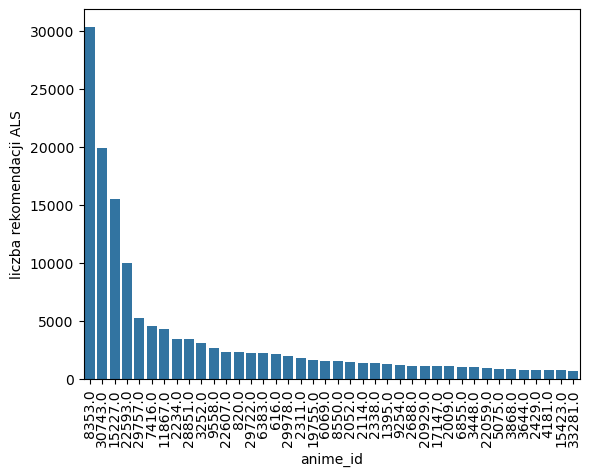

In [81]:
g10 = sns.barplot(graph10, x=graph10.index, y='vote')
g10.set_xticklabels(graph10['anime'], rotation=90)
g10.set(xlabel='anime_id', ylabel='liczba rekomendacji ALS')

In [69]:
dfs_pandas.sort_values(by='vote', ascending=False)

,user_id,anime,vote
36753,11251.0,11867.0,25.878250
13385,57453.0,30531.0,25.473480
29327,52963.0,3481.0,24.589502
82231,57453.0,23043.0,24.581934
32774,67760.0,29949.0,24.566105
...,...,...,...
196009,29286.0,20929.0,0.779892
124046,16392.0,5391.0,0.698184
128098,33173.0,5391.0,0.698184
192892,16392.0,4866.0,0.697208


In [82]:
graph11 = dfs_pandas.sort_values(by='vote', ascending=False)

In [83]:
graph11 = graph11.iloc[:40]

In [84]:
graph11.reset_index(inplace=True)

In [77]:
graph11.head()

,index,user_id,anime,vote
0,36753,11251.0,11867.0,25.878250
1,13385,57453.0,30531.0,25.473480
2,29327,52963.0,3481.0,24.589502
3,82231,57453.0,23043.0,24.581934
4,32774,67760.0,29949.0,24.566105


C:\Users\Tomasz\AppData\Local\Temp\ipykernel_1724\890670629.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g11.set_xticklabels(graph11['anime'], rotation=90)


[Text(0.5, 0, 'anime_id'), Text(0, 0.5, 'wartość rekomendacji ALS')]

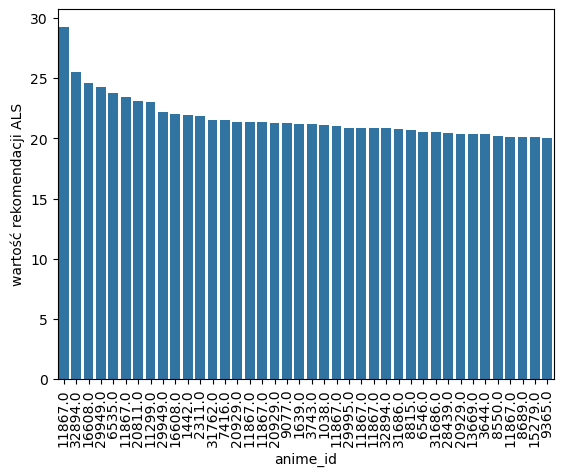

In [85]:
g11 = sns.barplot(graph11, x=graph11.index, y='vote')
g11.set_xticklabels(graph11['anime'], rotation=90)
g11.set(xlabel='anime_id', ylabel='wartość rekomendacji ALS')

In [87]:
anime1 = dfs_pandas[dfs_pandas['anime']==11867]

In [88]:
anime2 = dfs_pandas[dfs_pandas['anime']==30531]

In [89]:
anime3 = dfs_pandas[dfs_pandas['anime']==3481]

In [90]:
graph12 = pd.concat([anime1, anime2, anime3])

In [95]:
graph12.head()

,user_id,anime,vote
44,209.0,11867.0,11.338144
48,218.0,11867.0,12.099032
152,674.0,11867.0,11.615440
213,896.0,11867.0,11.255095
279,1199.0,11867.0,13.701178


<Axes: xlabel='vote', ylabel='Count'>

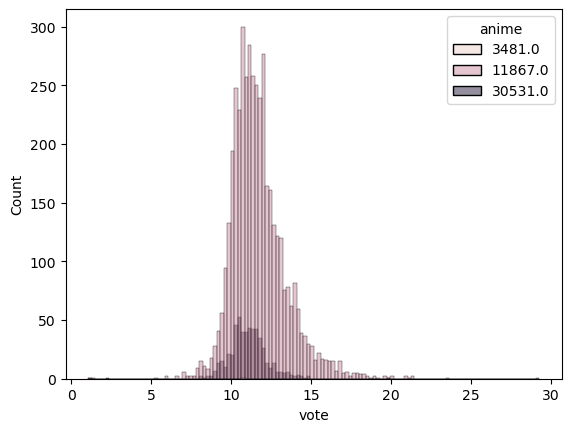

In [91]:
sns.histplot(data=graph12, x='vote', hue='anime')

[Text(0, 0.5, 'Liczba rekomendacji ALS'), Text(0.5, 0, 'Szacowany głos')]

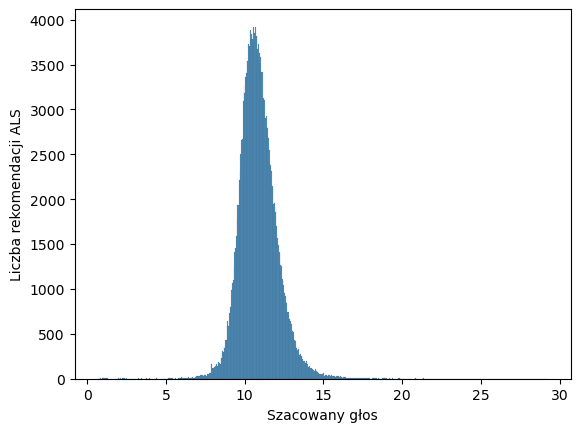

In [93]:
gn = sns.histplot(data=dfs_pandas, x='vote')
gn.set(ylabel='Liczba rekomendacji ALS', xlabel='Szacowany głos')

In [99]:
dfs_pandas['vote'].mean()

10.885897621549496

In [103]:
dfs_pandas['vote'].std()

1.2511651577406733

In [102]:
dfs_pandas[dfs_pandas['user_id']==66021]

,user_id,anime,vote
15346,66021.0,4536.0,13.734740
84192,66021.0,9053.0,13.639961
153038,66021.0,2651.0,13.473597


In [104]:
dfs_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206538 entries, 0 to 206537
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  206538 non-null  float64
 1   anime    206538 non-null  float64
 2   vote     206538 non-null  float64
dtypes: float64(3)
memory usage: 14.4 MB
